In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from utilities import draw_samples, render_flow_gif, plot_samples, affine_transformation
from robot_flows import smooth_robot_registration, wasserstein_flow, apply_spline_robot, apply_anisotropic_spline_robot

[KeOps] Warning : CUDA libraries not found or could not be loaded; Switching to CPU only.
[KeOps] Warning : OpenMP library not found, it must be downloaded through Homebrew for apple Silicon chips
[KeOps] Warning : OpenMP support is not available. Disabling OpenMP.


In [2]:
use_cuda = torch.cuda.is_available()
dtype = torch.cuda.FloatTensor if use_cuda else torch.FloatTensor
device = torch.device("cuda" if use_cuda else "cpu")
print("Using device:", device)

Using device: cpu


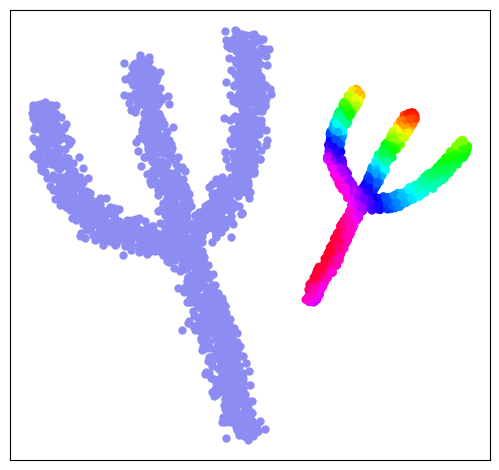

In [16]:
N, M = (2000, 2000) if not use_cuda else (10000, 10000)

X_i = draw_samples("data/shape_A.png", N, dtype).to(device)

theta = np.pi / 4  
scale = 1.8
translation = [0.5, -0.5]
noise = 0.01

Y_j = affine_transformation(X_i, theta, scale, translation, noise, device, dtype)
#Y_j = draw_samples("data/density_b.png", M, dtype).to(device)


A_i = torch.ones((N, 1), device=device) / N
B_j = torch.ones((1, M), device=device) / M

colors = (np.cos(10 * X_i[:, 0].cpu().numpy()) + np.cos(10 * X_i[:, 1].cpu().numpy()))

plot_samples(X_i, Y_j, colors)

## Wasserstein flows

In [17]:
lr = 0.05
epsilon = 0.0005
rho = 0.2
threshold = None

100%|██████████| 101/101 [00:06<00:00, 16.45it/s]


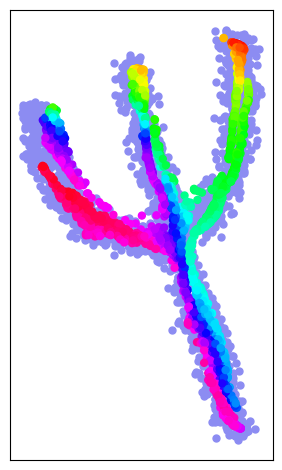

In [18]:
x_final, history = wasserstein_flow(X_i, Y_j, A_i, B_j, lr, epsilon, rho, save_history=True)

plot_samples(x_final, Y_j, colors)

In [19]:
render_flow_gif(history, X_i, Y_j, threshold, "wasserstein_flows.gif")

Render (60 frames)...
GIF saved : wasserstein_flows.gif


## Registration

In [20]:
mode = 'affine'
epsilon = 0.001
rho = 100
Nsteps = 20
threshold = None

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18), np.int64(19), np.int64(20)}


100%|██████████| 21/21 [00:01<00:00, 11.62it/s]


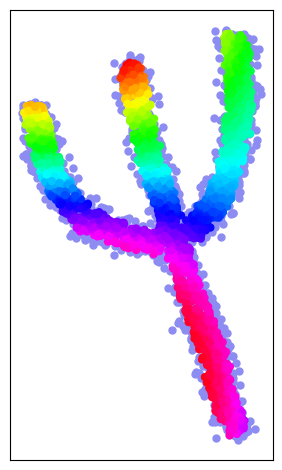

In [21]:
A, h, x_final, history = smooth_robot_registration(X_i, Y_j, A_i, B_j, mode=mode, epsilon=epsilon, rho=rho, Nsteps=Nsteps)
plot_samples(x_final, Y_j, colors)

In [22]:
render_flow_gif(history, X_i, Y_j, threshold, "robot_registration.gif", fps=7)

Render (26 frames)...
GIF saved : robot_registration.gif


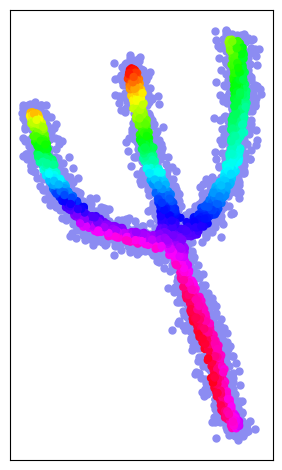

In [23]:
x_final_spline = apply_spline_robot(x_final, Y_j, A_i.flatten(), B_j.flatten(), epsilon=epsilon, rho=rho, sigma_spline=0.005)
plot_samples(x_final_spline, Y_j, colors)

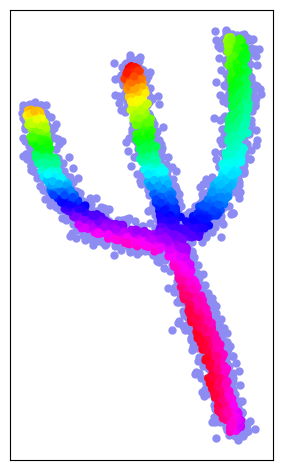

In [24]:
x_final_spline = apply_anisotropic_spline_robot(x_final, Y_j, A_i.flatten(), B_j.flatten(), epsilon=epsilon, rho=rho, sigma_spline=2.5)
plot_samples(x_final_spline, Y_j, colors)